# MUSIC for DOA

In [1]:
# Run this cell only once
%cd ".."
%pip install -e .

c:\Users\User\Documents\GitHub\uni\music-for-doa
Obtaining file:///C:/Users/User/Documents/GitHub/uni/music-for-doa
  Attempting uninstall: mfdoa
    Found existing installation: mfdoa 0.1
    Uninstalling mfdoa-0.1:
      Successfully uninstalled mfdoa-0.1
  Running setup.py develop for mfdoa
Note: you may need to restart the kernel to use updated packages.


In [2]:
from mfdoa.doa_estimators import DoaEstimatorMusic, DoaEstimatorMusicImproved, DoaEvaluator,DoaEstimatorMusic2Dmics
from mfdoa.generator import Generator
from mfdoa.visualizor import plot_music_doa_estimation
from mfdoa.utils import utils

import numpy as np
import matplotlib.pyplot as plt
import os

%reload_ext autoreload
%autoreload 2


## Examples for DOA estimation
### Using generation.json config file

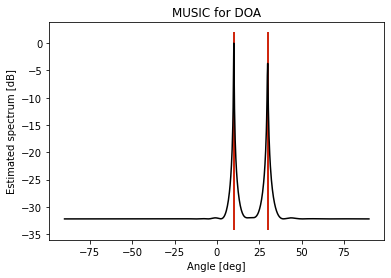

Predicted angles: ['10.00', '30.00']
Ground truth angles: [10, 30]
MAE: 1.563e-12 deg
MAX SNR: 32.22 dB


In [3]:
# Use config file for data generation.
gen = Generator()
data = gen.generate()
doamusic = DoaEstimatorMusic(gen)
doamusic.num_sources = 2
Pmusic, pred_angles = doamusic.get_doa_estimate(data)
Pmusic = utils.get_log_power_values(Pmusic)

SAVE_NAME = None #"music_cor.png"
# plot
plot_music_doa_estimation(gen.doas_deg, doamusic.theta, pred_angles, Pmusic, save_name=SAVE_NAME)
print(f"Predicted angles:",[f"{angle:.2F}" for angle in pred_angles])
print(f"Ground truth angles: {gen.doas_deg}")
mae = DoaEvaluator.get_mae(pred_angles, gen.doas_deg)
print(f"MAE: {mae:.4} deg")
max_snr = DoaEvaluator.get_max_SNR(Pmusic)
print(f"MAX SNR: {max_snr:.4} dB")


## GUI for illustration of sensitivity

In [4]:
# Use GUI parameter and visualize the selected configuration.

from ipywidgets import widgets

# @widgets.interact_manual(
@widgets.interact(
    noise_std_dev=(0.,10.),
    n_micros=(4,50,1),
    # dist_microphones=(1,200,1),
    n_samples=(100,10_000,100),
    delta_theta_gt=(1,20), # max should be lower than 30 for 3 DOA (3*30=90)
    delta_f=(0.,0.2,0.001) #f Could get too high
)
def visualize_doa_estimation(noise_std_dev=1,n_micros=10, n_samples=500, delta_theta_gt=10,delta_f=0.1):

    # Nicer with setter methods
    
    gen.set_configs(noise_std_dev,n_micros, n_samples, delta_theta_gt,delta_f)
    data = gen.generate()

    
    doamusic = DoaEstimatorMusic(gen)
    # doamusic.load_generator_config(gen)

    Pmusic, pred_angles = doamusic.get_doa_estimate(data)
    Pmusic = utils.get_log_power_values(Pmusic)

    plot_music_doa_estimation(gen.doas_deg, doamusic.theta, pred_angles, Pmusic)
    print(f"Predicted angles: {np.round(pred_angles,2)}\nGround truth angles: {gen.doas_deg}")
    mae = DoaEvaluator.get_mae(pred_angles, gen.doas_deg)
    print(f"MAE: {mae:.4} deg")
    max_snr = DoaEvaluator.get_max_SNR(Pmusic)
    print(f"MAX SNR: {max_snr:.4} dB")
    

interactive(children=(FloatSlider(value=1.0, description='noise_std_dev', max=10.0), IntSlider(value=10, descr…

## Computation of errors for different parameter configurations

In [5]:
# (Min, Max, Step size)
sweep_config = {
    "noise_std_dev": (0.,10.,0.5),
    "noise_ar1":(0.,0.7,0.05),
    "n_micros": (4,50,1),
    "n_samples":(50,500,50), 
    "delta_theta_gt":(1,20,2),
    "delta_f": (0.,0.2,0.01)
}

standard_vals = [3,0,10,100,5,0.1]
res_s = dict()

N_real = 100

for sweep_var in sweep_config.keys():
    print(sweep_var)
    res_s[sweep_var] = np.zeros((len(np.arange(*sweep_config[sweep_var])),3))
    noise_std_dev,noise_ar1, n_micros, n_samples, delta_theta_gt,delta_f = standard_vals
    sweep_n_config = dict(zip(sweep_config.keys(),standard_vals))
    for i,sweep_val in enumerate(np.arange(*sweep_config[sweep_var])):
        sweep_n_config[sweep_var] = sweep_val
        gen.set_configs(**sweep_n_config)
        doamusic.load_generator_config(gen)
        
        meas_reals = np.zeros((N_real,))
        for i_real in range(N_real):
            # FIXME Several realization would be needed to get a proper estimate
            data = gen.generate()

            Pmusic, pred_angles = doamusic.get_doa_estimate(data)
            Pmusic = utils.get_log_power_values(Pmusic)

            # plot_music_doa_estimation(gen.doas_deg, doamusic.theta, pred_angles, Pmusic)
            # print(f"Predicted angles: {np.round(pred_angles,2)}\nGround truth angles: {gen.doas_deg}")
            mae = DoaEvaluator.get_mae(pred_angles, gen.doas_deg)
            # print(f"MAE: {mae:.4} deg")
            meas_reals[i_real] = mae

        res_s[sweep_var][i,0] = sweep_val
        res_s[sweep_var][i,1] = np.mean(meas_reals)
        res_s[sweep_var][i,2] = np.std(meas_reals)


noise_std_dev
noise_ar1
n_micros
n_samples
delta_theta_gt
delta_f


xlegend_str ['1/9.5', '1/0.7', '1/49.0', '1/450.0', '1/19.0']
ylegend_str ['1/12.2', '1/2.0', '1/34.5', '1/0.9', '1/20.1']


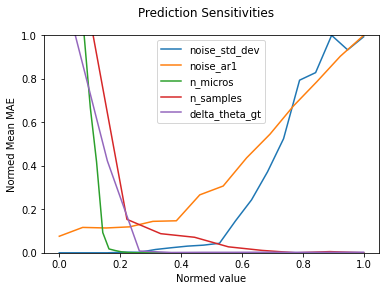

In [13]:
plot_sweeps = list(res_s.keys())[:-1]
for k in plot_sweeps:
    x = res_s[k][:,0]/max(res_s[k][:,0])
    y = res_s[k][:,1]/max(res_s[k][:,1])
    std_ = res_s[k][:,2]/max(res_s[k][:,1])
    plt.plot(x,y)
    # plt.fill_between(y, y - std_, y + std_,alpha=0.2)
    plt.ylim([0,1])
ylegend_str = [f"1/{max(res_s[k][:,1]):.1F}" for k in plot_sweeps]
xlegend_str = [f"1/{max(res_s[k][:,0]):.1F}" for k in plot_sweeps]
print("xlegend_str",xlegend_str)
print("ylegend_str",ylegend_str)
plt.ylabel("Normed MAE")
plt.xlabel("Normed value")
plt.legend(plot_sweeps)
plt.suptitle("Prediction Sensitivities")
plt.savefig("figures/error_plot.png")

## Get real data

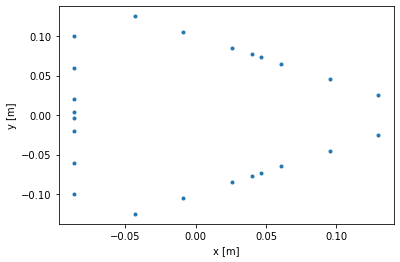

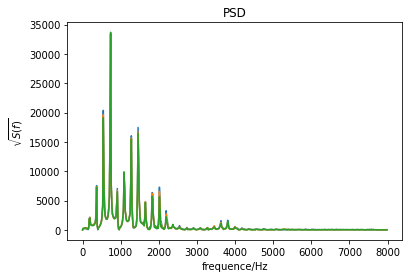

In [16]:
import json
from scipy.io import wavfile

with open('data/protocol.json') as json_file:  
    protocol = json.load(json_file)
    
microphone_3D_locations = np.array(protocol['geometry']['microphones']['locations'])
top_mics = np.isclose(microphone_3D_locations[:,2], 0.06123724)
microphone_2D_locations = microphone_3D_locations[top_mics, :2]

plt.plot(microphone_2D_locations[:,0],microphone_2D_locations[:,1],'.')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

arrayid = np.arange(48)[top_mics]
side1 = arrayid[:8]

# -----

rate, raw_data = wavfile.read('data/fq_sample3_spkr0_angle20.wav')

intv = np.arange(13000, 14000)
fs = 16000
Xw = np.fft.fft(raw_data[intv, 0] - np.mean(raw_data[intv,0]))
Xw1 = np.fft.fft(raw_data[intv, 1] - np.mean(raw_data[intv,1]))
Xw2 = np.fft.fft(raw_data[intv, 2] - np.mean(raw_data[intv,2]))
L = np.size(Xw)/2
plt.plot(np.arange(0, fs/2, fs/2/L), np.abs(Xw[:int(L)]))
plt.plot(np.arange(0, fs/2, fs/2/L), np.abs(Xw1[:int(L)]))
plt.plot(np.arange(0, fs/2, fs/2/L), np.abs(Xw2[:int(L)]))
plt.xlabel('frequence/Hz')
plt.ylabel('$\sqrt{S(f)}$')
plt.title('PSD')
plt.show()

# -----

f = 750
dataslice = raw_data[intv, :]
array = np.arange(48)[top_mics]
side1 = array[:8] # take 8 microphones which are in a line -> same as in sim
real_data = dataslice[:,side1].T



Predicted angles: [-22  22]
Ground truth angles: [-20  20]
MAE: 2.0 deg
MAX SNR: 13.072596900557665 dB


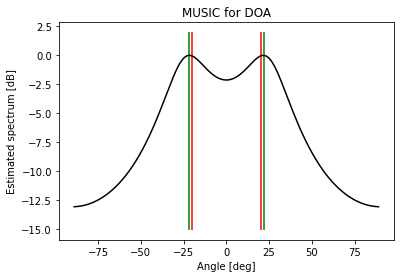

In [17]:
doamusic_real = DoaEstimatorMusic()
doamusic_real.pos_micros = np.array([0, 0.04, 0.08, 0.098, 0.102, 0.12, 0.16, 0.2])
doamusic_real.wavelen = 343 / f
doamusic_real.n_micros = 8
doamusic_real.num_sources = 2 # FIXME Why do we need 2 here? Is just one direction?

Pmusic, pred_angles = doamusic_real.get_doa_estimate(real_data)
Pmusic = utils.get_log_power_values(Pmusic)

gt_angles = np.array([-20, 20])
plot_music_doa_estimation(gt_angles, doamusic_real.theta, pred_angles, Pmusic, save_name="music_real.png")
print(f"Predicted angles: {np.round(pred_angles,2)}\nGround truth angles: {gt_angles}")
mae = DoaEvaluator.get_mae(pred_angles, gt_angles)
print(f"MAE: {mae:.4} deg")
max_snr = DoaEvaluator.get_max_SNR(Pmusic)
print(f"MAX SNR: {max_snr} dB")

## Multi Source Data

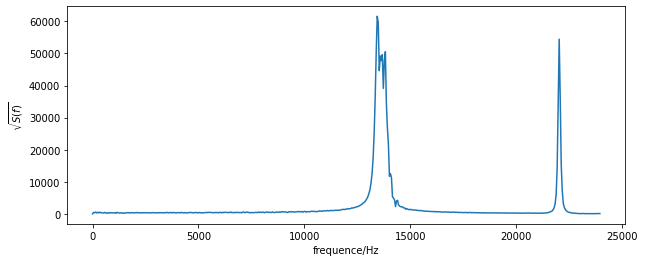

In [19]:
import math

true_angle = {"speechco":[42, 350, 222, 170], 
              "speechun":[8, 60, 188, 240], 
              "sweepco": [32, 66, 212, 246],
              "sweepun": [120, 150, 300, 330]}
true_angle_for_side = {0: {"speechco":[42, 10, -42, -10], 
                           "speechun":[8, 60, -8, -60], 
                           "sweepco": [32, 66, -32, -66],
                           "sweepun": [60, 30, -60, -30]},
                       1: {"speechco":[78, -78, 50, -50], 
                           "speechun":[68, -68, 30, -30], 
                           "sweepco": [88, -88, 24, -24],
                           "sweepun": [0, 30, -30]},
                       2: {"speechco":[18, -18, -70, 70], 
                           "speechun":[52, -52, 0], 
                           "sweepco": [28, -28, 6, -6],
                           "sweepun": [60, -60, 90, -90]}}

# three-sides detection
rate, raw_data = wavfile.read('data/sweep_uncorrelated.wav')
intv = np.arange(11000, 12000)
dataslice = raw_data[intv, :]
N = np.size(intv)
L = N/2
plt.figure(figsize=(10,4))

fs = rate
Xw = np.fft.fft(raw_data[intv, 0] - np.mean(raw_data[intv, 0]))
plt.plot(np.arange(0, fs/2, fs/2/L), np.abs(Xw[:int(L)]))
plt.xlabel('frequence/Hz')
plt.ylabel('$\sqrt{S(f)}$')
plt.show()

f1 = 13680
f2 = 22032
arg1 = np.array([math.floor(f1/fs*1000), math.floor((fs-f1)/fs*1000)])
arg2 = np.array([math.floor(f2/fs*1000), math.floor((fs-f2)/fs*1000)])
s1 = np.zeros((N, 24), dtype=complex)
s2 = s1
for j in range(24):
    S = np.fft.fft(dataslice[:, j])
    S1 = np.zeros(N, dtype=complex)
    S1[arg1] = S[arg1]
    S2 = np.zeros(N, dtype=complex)
    S2[arg2] = S[arg2]
    s1[:, j] = np.fft.ifft(S1)
    s2[:, j] = np.fft.ifft(S2)

In [20]:
wavelen = 343 / f
theta = np.arange(-90, 90, 1)
d = np.array([0, 0.04, 0.08, 0.098, 0.102, 0.12, 0.16, 0.2])
atheta = np.exp(-1j*2*np.pi/wavelen*np.kron(d, np.sin(theta/180*np.pi)).reshape(8, np.size(theta)))
atheta.shape

locations = microphone_2D_locations
theta = np.arange(0, 360, 1)
a = np.array([np.cos(theta/180*np.pi), np.sin(theta/180*np.pi)])
atheta = np.exp(-1j*2*np.pi/wavelen*np.dot(locations, a))
a.shape


(2, 360)

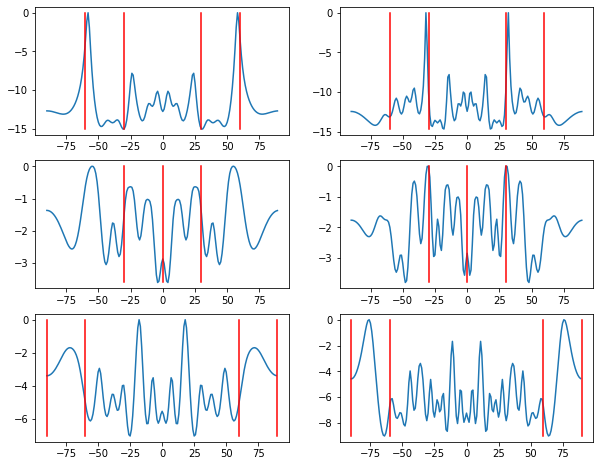

In [21]:
doaMusicReal = DoaEstimatorMusic()
doaMusicReal.theta = np.arange(-90, 90, 1)
doaMusicReal.pos_micros = np.array([0, 0.04, 0.08, 0.098, 0.102, 0.12, 0.16, 0.2])

doaMusicReal.num_sources = 2
doaMusicReal.n_micros = 8


plt.figure(figsize=(10,8))
for i in range(3):
    X1 = s1[:, 8*i:8*(i+1)].T
    X2 = s2[:, 8*i:8*(i+1)].T
    
    doaMusicReal.wavelen = 343 / f1
    Pmusic, pred_angles = doaMusicReal.get_doa_estimate(X1)
    Pmusic = utils.get_log_power_values(Pmusic)

    plt.subplot(3, 2,2*i+1)
    plt.plot(doaMusicReal.theta, Pmusic)
    for angle in true_angle_for_side[i]["sweepun"]:
        plt.plot([angle, angle],[Pmusic.min(), Pmusic.max()], 'r')
    
    doaMusicReal.wavelen = 343 / f2
    Pmusic, pred_angles = doaMusicReal.get_doa_estimate(X2)
    Pmusic = utils.get_log_power_values(Pmusic)
    
    plt.subplot(3, 2,2*i+2)
    plt.plot(doaMusicReal.theta, Pmusic)
    for angle in true_angle_for_side[i]["sweepun"]:
        plt.plot([angle, angle],[Pmusic.min(), Pmusic.max()], 'r')
        
plt.show()